# Projet Phase I
## Aviation Risk Prediction
 - **Business Context:** Une entreprise souhaite investir dans le secteur aéronautique en achetant et exploitant des avions commerciaux et privés. Cette analyse vise à identifier les aéronefs présentant le moins de risques pour guider les décisions d'investissement.
 - **Dataset:** NTSB Aviation Accident Database (1962-2023)
 - **Source:** https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses

#### =============================================================================
### 1. Configuration des paramètres et  importation des Bibliothèques
#### =============================================================================

In [1]:
#Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import warnings

# Configuration des paramètres
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Configuration terminée")
print(f"Date d'analyse: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Configuration terminée
Date d'analyse: 2025-06-14 12:42



### 2. CHARGEMENT ET EXPLORATION INITIALE DES DONNÉES


#### 2.1 Chargement des données et Aperçu général du dataset

In [2]:
# Chargement des données
df = pd.read_csv('../data/AviationData.csv', encoding='latin-1')

# Aperçu général du dataset
print(f"Forme du dataset: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"Taille mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Période couverte: {df['Event.Date'].min()} → {df['Event.Date'].max()}")

# Afficher les premières lignes
df.head()

Forme du dataset: 88,889 lignes × 31 colonnes
Taille mémoire: 135.01 MB
Période couverte: 1948-10-24 → 2022-12-29


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,NC6404,Stinson,108-3,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),Destroyed,NaN,N5069P,Piper,PA24-180,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.9222,-81.8781,NaN,NaN,Fatal(3),Destroyed,NaN,N5142R,Cessna,172M,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,N1168J,Rockwell,112,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,Fatal(1),Destroyed,NaN,N15NY,Cessna,501,No,NaN,NaN,NaN,NaN,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


#### 2.2 Analyse de la structure des données

In [3]:
# DataFrame d'information sur les colonnes
column_info = pd.DataFrame({
    'Nom_Colonne': df.columns,
    'Type_Data': df.dtypes,
    'Non_Null_Count': df.count(),
    'Null_Count': df.isnull().sum(),
    'Pourcentge_Null': (df.isnull().sum() / len(df) * 100).round(2),
    'Unique_Values': df.nunique()
})

print(column_info.to_string())

                                   Nom_Colonne Type_Data  Non_Null_Count  Null_Count  Pourcentge_Null  Unique_Values
Event.Id                              Event.Id    object           88889           0             0.00          87951
Investigation.Type          Investigation.Type    object           88889           0             0.00              2
Accident.Number                Accident.Number    object           88889           0             0.00          88863
Event.Date                          Event.Date    object           88889           0             0.00          14782
Location                              Location    object           88837          52             0.06          27758
Country                                Country    object           88663         226             0.25            219
Latitude                              Latitude    object           34382       54507            61.32          25592
Longitude                            Longitude    object        

#### 2.3 Identification des colonnes critiques pour l'analyse

In [4]:
critical_columns = {
    'Event.Date': 'Date de l\'accident',
    'Make': 'Fabricant de l\'aéronef', 
    'Model': 'Modèle de l\'aéronef',
    'Aircraft.Category': 'Catégorie d\'aéronef',
    'Total.Fatal.Injuries': 'Nombre de décès',
    'Total.Serious.Injuries': 'Nombre de blessés graves',
    'Purpose.of.flight': 'Objectif du vol',
    'Broad.phase.of.flight': 'Phase de vol lors de l\'accident',
    'Weather.Condition': 'Conditions météorologiques'
}

print("ANALYSE DES COLONNES CRITIQUES")

for col, description in critical_columns.items():
    if col in df.columns:
        completeness = (df[col].notna().sum() / len(df) * 100)
        print(f"\n{col} - {description}")
        print(f"   Complétude: {completeness:.1f}%")
        print(f"   Valeurs uniques: {df[col].nunique()}")

ANALYSE DES COLONNES CRITIQUES

Event.Date - Date de l'accident
   Complétude: 100.0%
   Valeurs uniques: 14782

Make - Fabricant de l'aéronef
   Complétude: 99.9%
   Valeurs uniques: 8237

Model - Modèle de l'aéronef
   Complétude: 99.9%
   Valeurs uniques: 12318

Aircraft.Category - Catégorie d'aéronef
   Complétude: 36.3%
   Valeurs uniques: 15

Total.Fatal.Injuries - Nombre de décès
   Complétude: 87.2%
   Valeurs uniques: 125

Total.Serious.Injuries - Nombre de blessés graves
   Complétude: 85.9%
   Valeurs uniques: 50

Purpose.of.flight - Objectif du vol
   Complétude: 93.0%
   Valeurs uniques: 26

Broad.phase.of.flight - Phase de vol lors de l'accident
   Complétude: 69.4%
   Valeurs uniques: 12

Weather.Condition - Conditions météorologiques
   Complétude: 94.9%
   Valeurs uniques: 4


### 3. Définition du Problème Métier
#### CONTEXTE MÉTIER ET OBJECTIFS
OBJECTIFS STRATÉGIQUES:
1. Sélection d'aéronefs à faible risque pour optimiser la sécurité
2. Diversification du portefeuille basée sur des données probantes
3. Réduction des coûts d'assurance grâce à des choix éclairés
4. Conformité réglementaire et excellence en matière de sécurité

MÉTRIQUES CLÉS À ANALYSER:
- Taux d'accidents par fabricant/modèle
- Taux de fatalité (gravité des accidents)
- Évolution temporelle de la sécurité
- Facteurs de risque (phase de vol, météo)
- Score de risque composite

### 4. PRÉPARATION ET NETTOYAGE DES DONNÉES
PRÉPARATION DES DONNÉES

In [5]:
# Fonction de nettoyage centralisée
def prepare_aviation_data(df):
    """
    Nettoie et prépare les données pour l'analyse
    """
    df_clean = df.copy()
    
    # Standardisation des fabricants
    df_clean['Make_Clean'] = df_clean['Make'].str.upper().str.strip()
    
    # Conversion et extraction des dates
    df_clean['Event.Date'] = pd.to_datetime(df_clean['Event.Date'], errors='coerce')
    df_clean['Year'] = df_clean['Event.Date'].dt.year
    df_clean['Month'] = df_clean['Event.Date'].dt.month
    df_clean['Decade'] = (df_clean['Year'] // 10) * 10
    
    # Calcul du nombre total de personnes impliquées
    df_clean['Total_People'] = (
        df_clean['Total.Fatal.Injuries'].fillna(0) + 
        df_clean['Total.Serious.Injuries'].fillna(0) + 
        df_clean['Total.Minor.Injuries'].fillna(0) + 
        df_clean['Total.Uninjured'].fillna(0)
    )
    
    # Classification de la sévérité
    df_clean['Severity_Category'] = pd.cut(
        df_clean['Total.Fatal.Injuries'].fillna(0), 
        bins=[-1, 0, 1, 5, float('inf')],
        labels=['No_Fatalities', 'Single_Fatality', 'Multiple_Fatalities', 'Mass_Fatalities']
    )
    
    # Combinaison Make + Model
    df_clean['Make_Model'] = df_clean['Make_Clean'] + ' ' + df_clean['Model'].fillna('UNKNOWN')
    
    return df_clean

# Application du nettoyage
df_clean = prepare_aviation_data(df)

print(f"Nettoyage terminé")
print(f"   Fabricants avant: {df['Make'].nunique()} → après: {df_clean['Make_Clean'].nunique()}")
print(f"   Période analysée: {df_clean['Year'].min()}-{df_clean['Year'].max()}")
print(f"   Total personnes impliquées: {df_clean['Total_People'].sum():,.0f}")

# Validation des données nettoyées
print("\n Validation des données:")
print(f"   Dates invalides: {df_clean['Event.Date'].isna().sum()}")
print(f"   Années valides: {df_clean['Year'].min()} - {df_clean['Year'].max()}")
print(f"   Catégories de sévérité: {df_clean['Severity_Category'].value_counts().to_dict()}")

Nettoyage terminé
   Fabricants avant: 8237 → après: 7587
   Période analysée: 1948-2022
   Total personnes impliquées: 540,945

 Validation des données:
   Dates invalides: 0
   Années valides: 1948 - 2022
   Catégories de sévérité: {'No_Fatalities': 71076, 'Single_Fatality': 8883, 'Multiple_Fatalities': 8211, 'Mass_Fatalities': 719}


### 5. ANALYSE EXPLORATOIRE DES DONNÉES

In [6]:
# 5.1 Analyse par fabricant
def analyze_manufacturers(df_clean, min_accidents=50):
    """
    Analyse détaillée des fabricants
    """
    manufacturer_stats = df_clean.groupby('Make_Clean').agg({
        'Event.Id': 'count',
        'Total.Fatal.Injuries': ['sum', 'mean'],
        'Total_People': ['sum', 'mean'],
        'Year': ['min', 'max']
    }).round(2)
    
    manufacturer_stats.columns = [
        'Accident_Count', 'Total_Deaths', 'Avg_Deaths_Per_Accident', 
        'Total_People_Involved', 'Avg_People_Per_Accident', 
        'First_Accident_Year', 'Last_Accident_Year'
    ]
    
    # Calculs supplémentaires
    manufacturer_stats['Fatality_Rate_Percent'] = (
        manufacturer_stats['Total_Deaths'] / 
        manufacturer_stats['Total_People_Involved'] * 100
    ).round(2)
    
    manufacturer_stats['Years_Active'] = (
        manufacturer_stats['Last_Accident_Year'] - 
        manufacturer_stats['First_Accident_Year'] + 1
    )
    
    manufacturer_stats['Annual_Accident_Rate'] = (
        manufacturer_stats['Accident_Count'] / 
        manufacturer_stats['Years_Active']
    ).round(2)
    
    # Filtrer les fabricants significatifs
    significant = manufacturer_stats[manufacturer_stats['Accident_Count'] >= min_accidents]
    
    return manufacturer_stats, significant

manufacturer_stats, significant_manufacturers = analyze_manufacturers(df_clean)

print(f"\n Analyse des fabricants:")
print(f"   Total fabricants: {len(manufacturer_stats)}")
print(f"   Fabricants significatifs (≥50 accidents): {len(significant_manufacturers)}")

# Top 10 fabricants
print("\n Top 10 fabricants par nombre d'accidents:")
top_manufacturers = manufacturer_stats.nlargest(10, 'Accident_Count')
for i, (manufacturer, row) in enumerate(top_manufacturers.iterrows(), 1):
    print(f"{i:2d}. {manufacturer:<15} : {row['Accident_Count']:>6.0f} accidents")

# Analyse temporelle
yearly_stats = df_clean.groupby('Year').agg({
    'Event.Id': 'count',
    'Total.Fatal.Injuries': 'sum',
    'Total_People': 'sum'
}).reset_index()

yearly_stats.columns = ['Year', 'Accidents', 'Fatalities', 'Total_People']
yearly_stats['Fatality_Rate'] = (
    yearly_stats['Fatalities'] / yearly_stats['Total_People'] * 100
).round(2)

print(f"\n Tendances temporelles:")
print(f"   Pic d'accidents: {yearly_stats.loc[yearly_stats['Accidents'].idxmax(), 'Year']:.0f} "
      f"({yearly_stats['Accidents'].max():.0f} accidents)")
print(f"   Année la plus meurtrière: {yearly_stats.loc[yearly_stats['Fatalities'].idxmax(), 'Year']:.0f} "
      f"({yearly_stats['Fatalities'].max():.0f} décès)")

# Tendance récente
recent_trend = yearly_stats[yearly_stats['Year'] >= 2010]['Accidents'].mean()
past_trend = yearly_stats[(yearly_stats['Year'] >= 1990) & (yearly_stats['Year'] < 2000)]['Accidents'].mean()
print(f"   Évolution: {((recent_trend - past_trend) / past_trend * 100):.1f}% depuis les années 90")



 Analyse des fabricants:
   Total fabricants: 7587
   Fabricants significatifs (≥50 accidents): 98

 Top 10 fabricants par nombre d'accidents:
 1. CESSNA          :  27149 accidents
 2. PIPER           :  14870 accidents
 3. BEECH           :   5372 accidents
 4. BOEING          :   2745 accidents
 5. BELL            :   2722 accidents
 6. MOONEY          :   1334 accidents
 7. ROBINSON        :   1230 accidents
 8. GRUMMAN         :   1172 accidents
 9. BELLANCA        :   1045 accidents
10. HUGHES          :    932 accidents

 Tendances temporelles:
   Pic d'accidents: 1982 (3593 accidents)
   Année la plus meurtrière: 1996 (2533 décès)
   Évolution: -28.7% depuis les années 90


### 6. CALCUL DES MÉTRIQUES DE RISQUE

In [7]:
# Fonction de calcul du score de risque composite
def calculate_risk_scores(manufacturer_stats, min_accidents=50):
    """
    Calcule un score de risque composite pour chaque fabricant
    """
    # Filtrer les fabricants significatifs
    significant = manufacturer_stats[manufacturer_stats['Accident_Count'] >= min_accidents].copy()
    
    # Préparer les données pour le scoring
    score_data = significant[[
        'Annual_Accident_Rate', 
        'Fatality_Rate_Percent', 
        'Avg_Deaths_Per_Accident'
    ]].fillna(0)
    
    # Normalisation (0-100)
    scaler = MinMaxScaler(feature_range=(0, 100))
    score_normalized = pd.DataFrame(
        scaler.fit_transform(score_data),
        index=score_data.index,
        columns=['Annual_Risk_Score', 'Fatality_Risk_Score', 'Severity_Risk_Score']
    )
    
    # Score composite pondéré
    significant['Composite_Risk_Score'] = (
        score_normalized['Annual_Risk_Score'] * 0.4 +      # Fréquence
        score_normalized['Fatality_Risk_Score'] * 0.4 +    # Létalité  
        score_normalized['Severity_Risk_Score'] * 0.2      # Sévérité
    ).round(1)
    
    # Classification par niveau de risque
    significant['Risk_Category'] = pd.cut(
        significant['Composite_Risk_Score'],
        bins=[0, 20, 40, 60, 80, 100],
        labels=['Très_Faible', 'Faible', 'Modéré', 'Élevé', 'Très_Élevé']
    )
    
    return significant

# Application du calcul
manufacturers_with_risk = calculate_risk_scores(manufacturer_stats)

print("\n Distribution des niveaux de risque:")
risk_distribution = manufacturers_with_risk['Risk_Category'].value_counts()
for category, count in risk_distribution.items():
    percentage = (count / len(manufacturers_with_risk) * 100)
    print(f"   {category:<12}: {count:>3} fabricants ({percentage:>5.1f}%)")

# Identification des meilleurs et pires fabricants
print("\n TOP 5 FABRICANTS LES PLUS SÛRS:")
safest = manufacturers_with_risk.nsmallest(5, 'Composite_Risk_Score')
for i, (manufacturer, row) in enumerate(safest.iterrows(), 1):
    print(f"{i}. {manufacturer:<12}: Score {row['Composite_Risk_Score']:>5.1f} ({row['Risk_Category']})")

print("\n TOP 5 FABRICANTS LES PLUS RISQUÉS:")
riskiest = manufacturers_with_risk.nlargest(5, 'Composite_Risk_Score')
for i, (manufacturer, row) in enumerate(riskiest.iterrows(), 1):
    print(f"{i}. {manufacturer:<12}: Score {row['Composite_Risk_Score']:>5.1f} ({row['Risk_Category']})")


 Distribution des niveaux de risque:
   Très_Faible :  67 fabricants ( 68.4%)
   Faible      :  28 fabricants ( 28.6%)
   Modéré      :   3 fabricants (  3.1%)
   Très_Élevé  :   0 fabricants (  0.0%)
   Élevé       :   0 fabricants (  0.0%)

 TOP 5 FABRICANTS LES PLUS SÛRS:
1. RAVEN       : Score   0.2 (Très_Faible)
2. GRUMMAN ACFT ENG COR-SCHWEIZER: Score   0.6 (Très_Faible)
3. BALLOON WORKS: Score   1.5 (Très_Faible)
4. BOMBARDIER INC: Score   2.3 (Très_Faible)
5. WACO        : Score   3.2 (Très_Faible)

 TOP 5 FABRICANTS LES PLUS RISQUÉS:
1. CESSNA      : Score  55.1 (Modéré)
2. AGUSTA      : Score  41.6 (Modéré)
3. LANCAIR     : Score  41.5 (Modéré)
4. MITSUBISHI  : Score  37.1 (Faible)
5. RANS        : Score  37.0 (Faible)


###### =============================================================================
### 7. VISUALISATIONS
###### =============================================================================

#### 7.1 Configuration des visualisations

In [8]:
fig_size_single = (12, 8)
fig_size_double = (16, 8)
colors_main = sns.color_palette("husl", 10)

#### 7.2 Graphique 1: Top fabricants par nombre d'accidents

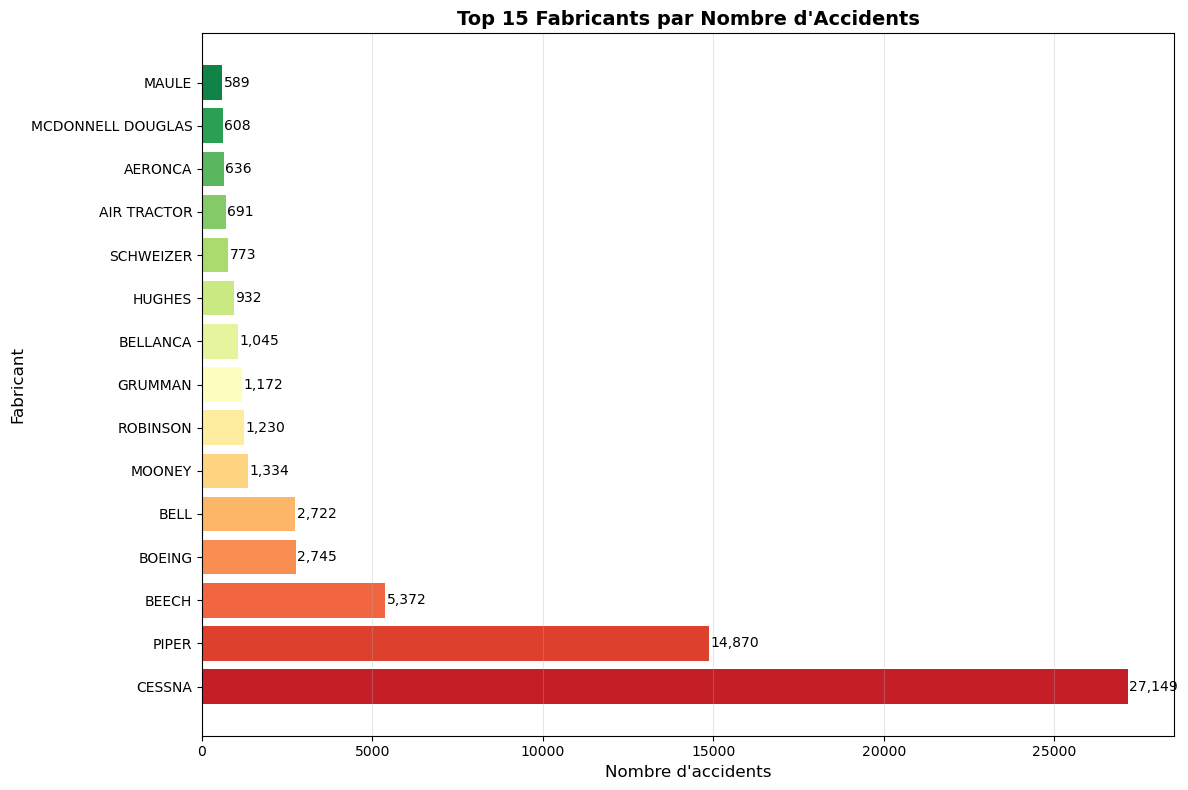

In [9]:
plt.figure(figsize=fig_size_single)
top_15_manufacturers = manufacturer_stats.nlargest(15, 'Accident_Count')
bars = plt.barh(top_15_manufacturers.index, top_15_manufacturers['Accident_Count'], 
                color=sns.color_palette("RdYlGn", len(top_15_manufacturers)))

# Ajouter les valeurs
for bar in bars:
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height()/2, 
            f'{int(width):,}', ha='left', va='center')

plt.xlabel('Nombre d\'accidents', fontsize=12)
plt.ylabel('Fabricant', fontsize=12)
plt.title('Top 15 Fabricants par Nombre d\'Accidents', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#### 7.3 Graphique 2: Évolution temporelle (double axe)

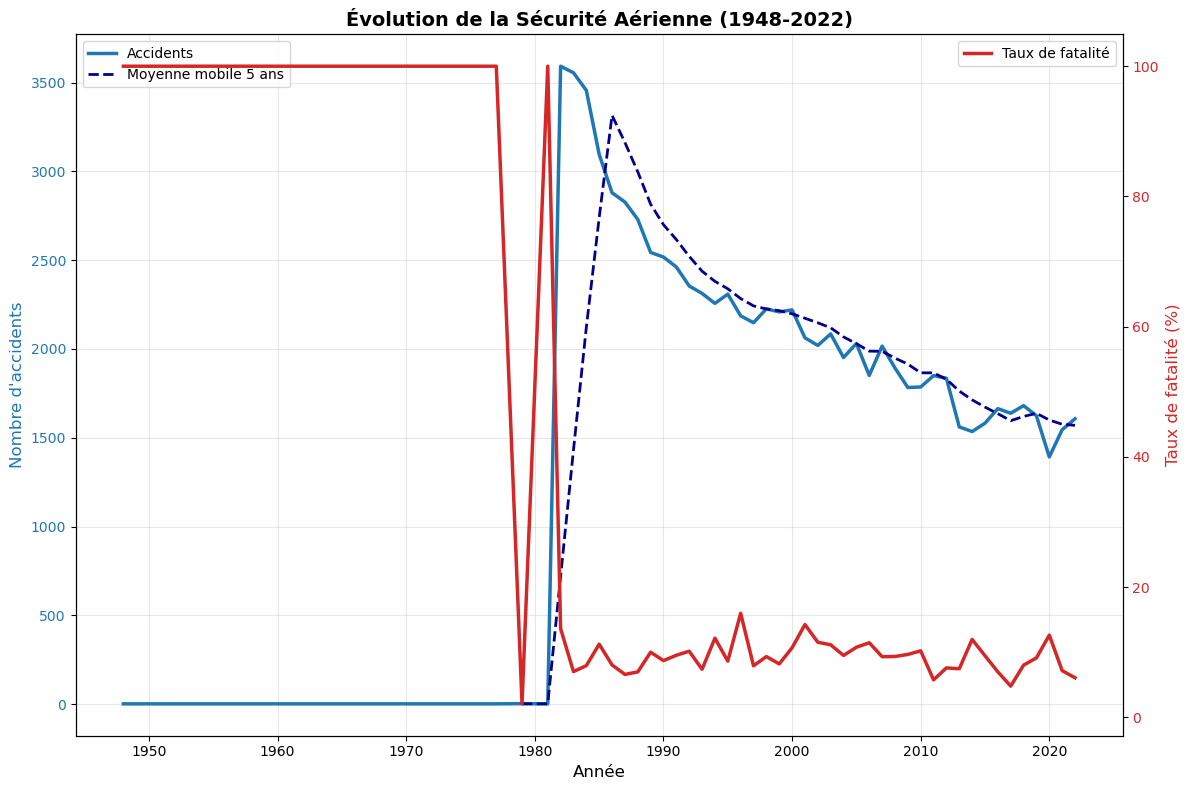

In [10]:
fig, ax1 = plt.subplots(figsize=fig_size_single)

# Axe 1: Nombre d'accidents
color1 = 'tab:blue'
ax1.set_xlabel('Année', fontsize=12)
ax1.set_ylabel('Nombre d\'accidents', color=color1, fontsize=12)
ax1.plot(yearly_stats['Year'], yearly_stats['Accidents'], 
         color=color1, linewidth=2.5, label='Accidents')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Moyenne mobile
moving_avg = yearly_stats['Accidents'].rolling(window=5).mean()
ax1.plot(yearly_stats['Year'], moving_avg, color='darkblue', 
         linestyle='--', linewidth=2, label='Moyenne mobile 5 ans')

# Axe 2: Taux de fatalité
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Taux de fatalité (%)', color=color2, fontsize=12)
ax2.plot(yearly_stats['Year'], yearly_stats['Fatality_Rate'], 
         color=color2, linewidth=2.5, label='Taux de fatalité')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Évolution de la Sécurité Aérienne (1948-2022)', fontsize=14, fontweight='bold')
fig.tight_layout()
ax1.legend(loc='upper left')  
ax2.legend(loc='upper right') 

plt.show()

#### 7.4 Graphique 3: Scatter plot Risque vs Fréquence

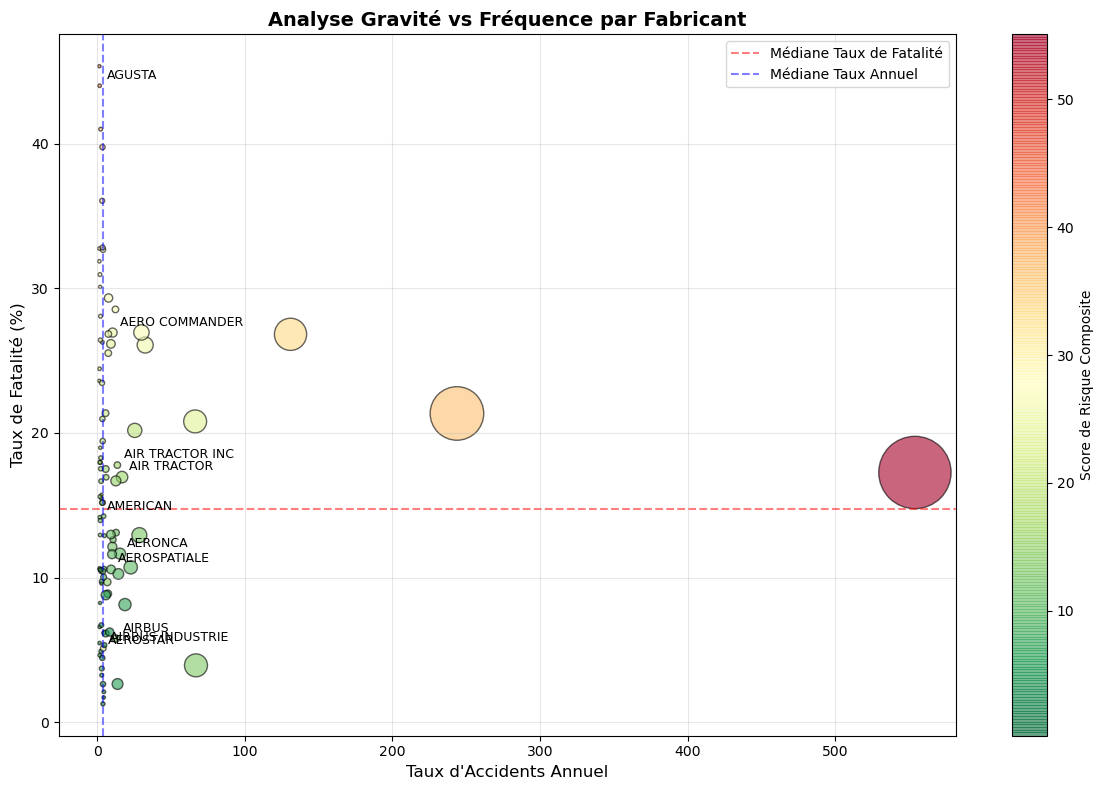

In [11]:
plt.figure(figsize=fig_size_single)
scatter = plt.scatter(manufacturers_with_risk['Annual_Accident_Rate'], 
                     manufacturers_with_risk['Fatality_Rate_Percent'],
                     s=manufacturers_with_risk['Accident_Count']/10,
                     c=manufacturers_with_risk['Composite_Risk_Score'],
                     cmap='RdYlGn_r', alpha=0.6, edgecolors='black')

# Labels pour les principaux fabricants
for manufacturer, row in manufacturers_with_risk.head(10).iterrows():
    plt.annotate(manufacturer, 
                (row['Annual_Accident_Rate'], row['Fatality_Rate_Percent']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.colorbar(scatter, label='Score de Risque Composite')
plt.xlabel('Taux d\'Accidents Annuel', fontsize=12)
plt.ylabel('Taux de Fatalité (%)', fontsize=12)
plt.title('Analyse Gravité vs Fréquence par Fabricant', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Lignes de référence
plt.axhline(y=manufacturers_with_risk['Fatality_Rate_Percent'].median(), 
           color='red', linestyle='--', alpha=0.5, label='Médiane Taux de Fatalité')
plt.axvline(x=manufacturers_with_risk['Annual_Accident_Rate'].median(), 
           color='blue', linestyle='--', alpha=0.5, label='Médiane Taux Annuel')
plt.legend()
plt.tight_layout()
plt.show()

#### 7.5 Graphique 4: Heatmap mensuelle (années récentes)

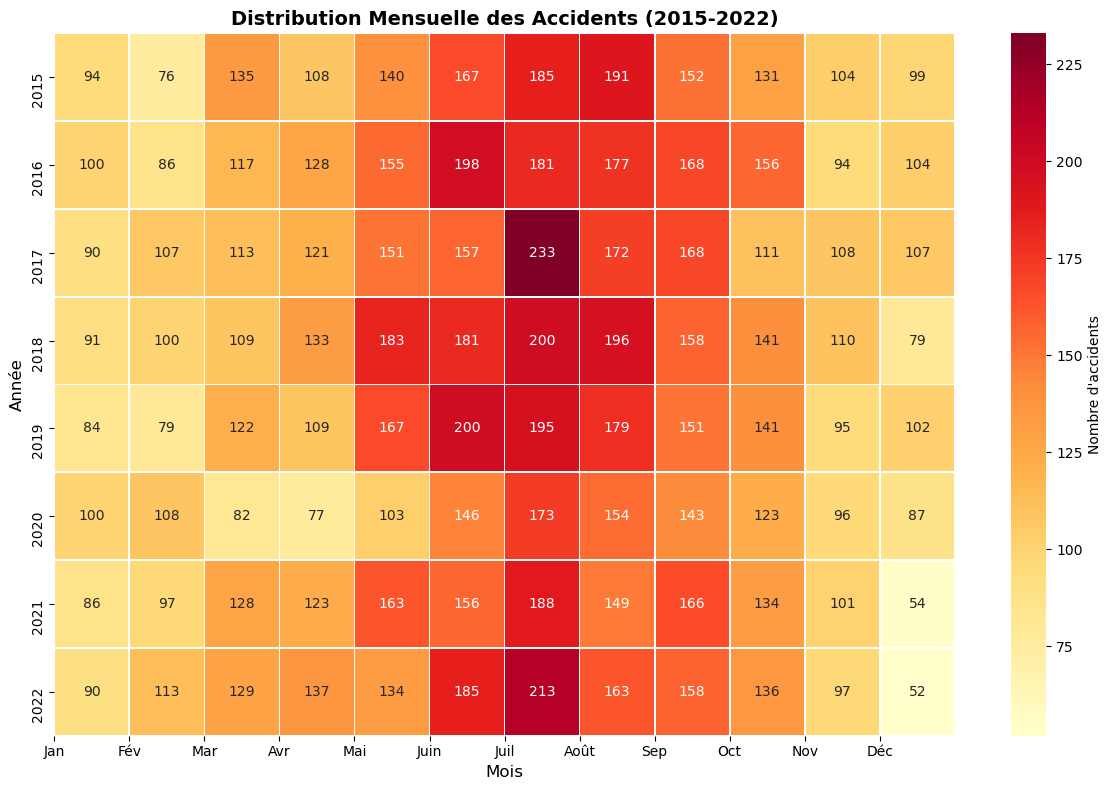

In [12]:
recent_data = df_clean[(df_clean['Year'] >= 2015) & (df_clean['Year'] <= 2022)]
heatmap_data = recent_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)

plt.figure(figsize=fig_size_single)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Nombre d\'accidents'})
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Année', fontsize=12)
plt.title('Distribution Mensuelle des Accidents (2015-2022)', fontsize=14, fontweight='bold')

# Labels des mois
month_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 
                'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
plt.xticks(range(12), month_labels)
plt.tight_layout()
plt.show()

# Dashboard récapitulatif

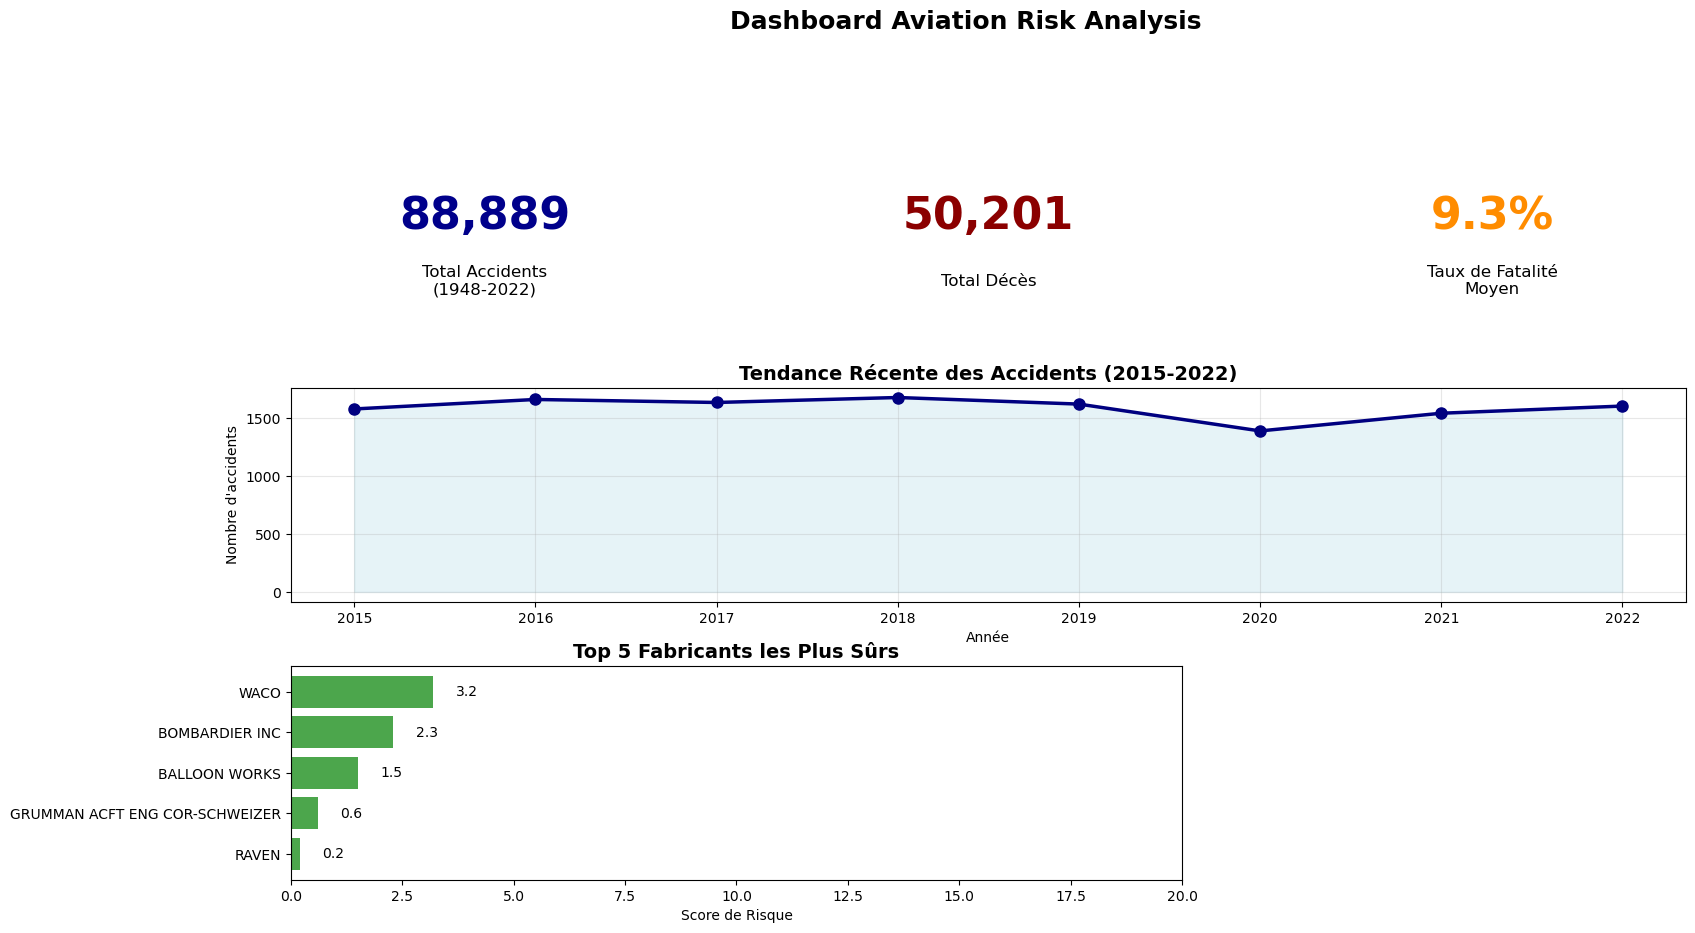

In [13]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Métrique 1: Total accidents
ax1 = fig.add_subplot(gs[0, 0])
ax1.text(0.5, 0.5, f"{len(df_clean):,}", ha='center', va='center', 
         fontsize=32, fontweight='bold', color='darkblue')
ax1.text(0.5, 0.2, "Total Accidents\n(1948-2022)", ha='center', va='center', fontsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')

# Métrique 2: Total décès
ax2 = fig.add_subplot(gs[0, 1])
total_deaths = df_clean['Total.Fatal.Injuries'].sum()
ax2.text(0.5, 0.5, f"{int(total_deaths):,}", ha='center', va='center', 
         fontsize=32, fontweight='bold', color='darkred')
ax2.text(0.5, 0.2, "Total Décès", ha='center', va='center', fontsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

# Métrique 3: Taux de fatalité moyen
ax3 = fig.add_subplot(gs[0, 2])
avg_fatality_rate = (df_clean['Total.Fatal.Injuries'].sum() / df_clean['Total_People'].sum() * 100)
ax3.text(0.5, 0.5, f"{avg_fatality_rate:.1f}%", ha='center', va='center', 
         fontsize=32, fontweight='bold', color='darkorange')
ax3.text(0.5, 0.2, "Taux de Fatalité\nMoyen", ha='center', va='center', fontsize=12)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')

# Graphique tendance récente
ax4 = fig.add_subplot(gs[1, :])
recent_trend = df_clean[df_clean['Year'] >= 2015].groupby('Year')['Event.Id'].count()
ax4.plot(recent_trend.index, recent_trend.values, marker='o', 
         markersize=8, linewidth=2.5, color='navy')
ax4.fill_between(recent_trend.index, recent_trend.values, alpha=0.3, color='lightblue')
ax4.set_title('Tendance Récente des Accidents (2015-2022)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Année')
ax4.set_ylabel('Nombre d\'accidents')
ax4.grid(True, alpha=0.3)

# Top 5 fabricants sûrs
ax5 = fig.add_subplot(gs[2, 0:2])
y_pos = np.arange(len(safest))
bars = ax5.barh(y_pos, safest['Composite_Risk_Score'], color='green', alpha=0.7)
ax5.set_yticks(y_pos)
ax5.set_yticklabels(safest.index)
ax5.set_xlabel('Score de Risque')
ax5.set_title('Top 5 Fabricants les Plus Sûrs', fontsize=14, fontweight='bold')
ax5.set_xlim(0, 20)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax5.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center')



plt.suptitle('Dashboard Aviation Risk Analysis', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

#### 8. ANALYSES COMPLÉMENTAIRES

In [14]:
# Analyse par phase de vol
phase_analysis = df_clean['Broad.phase.of.flight'].value_counts().head(10)
print("\n Top 10 phases de vol les plus accidentogènes:")
for i, (phase, count) in enumerate(phase_analysis.items(), 1):
    percentage = (count / len(df_clean) * 100)
    print(f"{i:2d}. {phase:<20}: {count:>6,} ({percentage:>5.1f}%)")

# Analyse météorologique
weather_analysis = df_clean.groupby('Weather.Condition').agg({
    'Event.Id': 'count',
    'Total.Fatal.Injuries': 'sum',
    'Total_People': 'sum'
}).sort_values('Event.Id', ascending=False).head(5)

weather_analysis['Fatality_Rate'] = (
    weather_analysis['Total.Fatal.Injuries'] / 
    weather_analysis['Total_People'] * 100
).round(2)

print("\n Impact des conditions météorologiques:")
for condition, row in weather_analysis.iterrows():
    print(f"   {condition}: {row['Event.Id']:,} accidents, "
          f"taux de fatalité: {row['Fatality_Rate']:.1f}%")

# Analyse par catégorie d'aéronef
category_analysis = df_clean['Aircraft.Category'].value_counts().head(5)
print("\n Répartition par catégorie d'aéronef:")
for category, count in category_analysis.items():
    percentage = (count / len(df_clean) * 100)
    print(f"   {category}: {count:,} ({percentage:.1f}%)")


 Top 10 phases de vol les plus accidentogènes:
 1. Landing             : 15,428 ( 17.4%)
 2. Takeoff             : 12,493 ( 14.1%)
 3. Cruise              : 10,269 ( 11.6%)
 4. Maneuvering         :  8,144 (  9.2%)
 5. Approach            :  6,546 (  7.4%)
 6. Climb               :  2,034 (  2.3%)
 7. Taxi                :  1,958 (  2.2%)
 8. Descent             :  1,887 (  2.1%)
 9. Go-around           :  1,353 (  1.5%)
10. Standing            :    945 (  1.1%)

 Impact des conditions météorologiques:
   VMC: 77,303.0 accidents, taux de fatalité: 6.9%
   IMC: 5,976.0 accidents, taux de fatalité: 21.0%
   UNK: 856.0 accidents, taux de fatalité: 17.8%
   Unk: 262.0 accidents, taux de fatalité: 4.3%

 Répartition par catégorie d'aéronef:
   Airplane: 27,617 (31.1%)
   Helicopter: 3,440 (3.9%)
   Glider: 508 (0.6%)
   Balloon: 231 (0.3%)
   Gyrocraft: 173 (0.2%)


#### 9. RECOMMANDATIONS FINALES ET CONCLUSIONS

In [15]:
# Synthèse des recommandations
print("\n FABRICANTS RECOMMANDÉS POUR INVESTISSEMENT:")
print("(Basé sur le score de risque composite < 20)")
print("-" * 60)

for i, (manufacturer, row) in enumerate(safest.iterrows(), 1):
    print(f"\n{i}. {manufacturer}")
    print(f"    Score de risque: {row['Composite_Risk_Score']:.1f}/100")
    print(f"    Taux annuel d'accidents: {row['Annual_Accident_Rate']:.1f}")
    print(f"    Taux de fatalité: {row['Fatality_Rate_Percent']:.1f}%")
    print(f"    Période d'activité: {int(row['First_Accident_Year'])}-{int(row['Last_Accident_Year'])}")
    print(f"    Total accidents: {row['Accident_Count']:.0f}")                             


 FABRICANTS RECOMMANDÉS POUR INVESTISSEMENT:
(Basé sur le score de risque composite < 20)
------------------------------------------------------------

1. RAVEN
    Score de risque: 0.2/100
    Taux annuel d'accidents: 3.9
    Taux de fatalité: 1.3%
    Période d'activité: 1982-2003
    Total accidents: 86

2. GRUMMAN ACFT ENG COR-SCHWEIZER
    Score de risque: 0.6/100
    Taux annuel d'accidents: 4.5
    Taux de fatalité: 1.7%
    Période d'activité: 2009-2021
    Total accidents: 58

3. BALLOON WORKS
    Score de risque: 1.5/100
    Taux annuel d'accidents: 4.0
    Taux de fatalité: 2.6%
    Période d'activité: 1982-2018
    Total accidents: 147

4. BOMBARDIER INC
    Score de risque: 2.3/100
    Taux annuel d'accidents: 4.5
    Taux de fatalité: 2.1%
    Période d'activité: 2008-2022
    Total accidents: 68

5. WACO
    Score de risque: 3.2/100
    Taux annuel d'accidents: 3.5
    Taux de fatalité: 4.5%
    Période d'activité: 1982-2022
    Total accidents: 143


#### 9.2 Facteurs de risque à surveiller
FACTEURS DE RISQUE À SURVEILLER :
1. PHASES DE VOL CRITIQUES:
 - Landing et Take-off: phases les plus accidentogènes
 - Cruise: phase avec le plus de fatalités

3. CONDITIONS MÉTÉOROLOGIQUES:
 - IMC (Instrument Meteorological Conditions): taux de fatalité élevé
 - Prévoir des restrictions opérationnelles adaptées

4. ÉVOLUTION TEMPORELLE:
 - Amélioration constante depuis 2000
 - Privilégier les modèles récents (post-2010)

#### 9.3 Stratégie d'investissement recommandée
STRATÉGIE D'INVESTISSEMENT RECOMMANDÉE :
1. DIVERSIFICATION DU PORTEFEUILLE :
- Mixer 2-3 fabricants du top 5 sûrs
- Inclure différentes catégories d'aéronefs
- Équilibrer entre aviation commerciale et privée

2. CRITÈRES DE SÉLECTION DES MODÈLES :
-  Privilégier les modèles avec > 5 ans d'historique
- Score de risque fabricant < 20
- Taux de fatalité < 10%
- Éviter les modèles en fin de vie

3. GESTION OPÉRATIONNELLE :
 - Formation renforcée sur les phases critiques
 - Protocoles stricts pour conditions météo adverses
 - Maintenance préventive rigoureuse
 - Assurance adaptée au profil de risque

#### 9.4 Prochaines étapes
PROCHAINES ÉTAPES :
1. Analyse approfondie des modèles spécifiques des fabricants recommandés
2. Étude des coûts d'acquisition et d'exploitation
3. Analyse du marché de la location et du transport aérien
4. Évaluation des besoins en formation et certification
5. Développement d'un modèle prédictif de risque

#### 9.5 Limitations et considérations
LIMITATIONS DE L'ANALYSE :
-  Données limitées aux accidents rapportés (biais de survie)
- Pas de normalisation par nombre de vols ou heures de vol
- Évolution technologique non prise en compte directement
- Facteurs économiques et réglementaires non inclus

CONCLUSION :
Cette analyse fournit une base solide pour la prise de décision d'investissement dans le secteur aéronautique. Les fabricants
identifiés comme 'sûrs' présentent un profil de risque favorable pour débuter une activité dans ce domaine.